# 01 - Basic Operations and Basic Concepts: generating the forward data

In this tutorial, you will learn the majority of the basic operations of the package, including loading and saving meshes, calculating the forward data, calculating the Jacobian, etc, as well as a brief explanation of the physical meanings of them. In this first part, we will primarily focus on the forward data generation part.

For full documentation of all the functions available, please refer to the manual in the "docs" folder, which is available in both html and PDF formats.

We first start with loading a standard mesh. For the time being, let us use a 2D disk example. This package supports (so far) three mesh types: standard, fluorescence, and DCS, and example meshes are provided in the "meshes" folder. The standard mesh is the most commonly used type, e.g. in fNIRS and DOT. The meanings of the other two types will explained in the latter parts of this tutorial.

## CW and FD

In [1]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# Now load the mesh
mesh = ff.base.stndmesh()
mesh.from_file('../meshes/standard/circle2000_86_stnd')

Fixed sources
Sources integration functions loaded
Fixed detectors
Detectors integration functions loaded


Essentially, what we need to do is that we first create an object of the appropriate class, and call the relevant method to populate its fields. 

In the printout, "fixed" sources and detectors mean that the locations of the optodes shall remain *exactly* where they are defined to be without checking, even though they might be placed outside of the mesh by mistake. Integration functions define the relationship between an optode and the nodes in the mesh: the calculations done on a FEM mesh are defined only on the nodes in the mesh, but suppose an optode is NOT placed on a node but in the middle of a triangle/tetrahedron (an "element") what should we do? The solution is to define the fluence at the optode as a weighted average of nodes of the element it is in, and the weights are called "integration functions". For the curious reader, they are exactly the "Barycentric coordinates".

The package can, of course, also take care of non-fixed sources (which is in face to be recommended in most cases) and calculate these integration functions. We will discuss this later in the full head tutorial.

Now, let's simulate some CW data and visualize it.

/tmp/ipykernel_5619/610794123.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


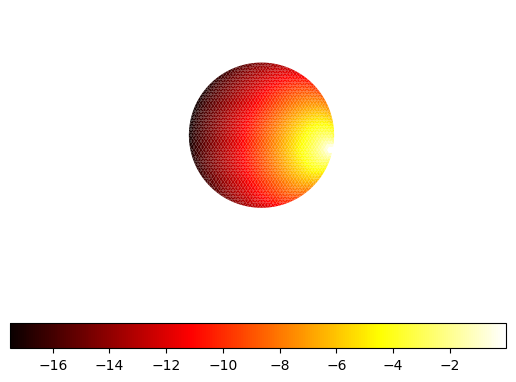

In [3]:
data, info = mesh.femdata(0) # 0 means modulation frequency is 0Hz, i.e. CW
# log amplitude of the first source
fig, ax = ff.visualize.plotimage(mesh, np.log(np.abs(data.phi[:,0])))
fig.show()

If you have had experience using the Matlab version before, this should be quite familiar. In "data", we have the fluence fields produced by each source, as well as the boundary measurements at each detector. "info" contains the convergence information of the iterative solver. This is usually irrelevant unless the code fails and you need to understand what may have gone wrong. You can, of course, change the convergence criteria of the solver, but that is beyond the scope of this turorial. Please refer to the API documentation for details.

Like the old Matlab version, you can choose between the GPU (CUDA only) and the CPU solver. If not specified, the package will choose automatically for you. If you do would like to manually choose, it can be done like this

In [4]:
data, info = mesh.femdata(0, solver='gpu') # or 'cpu', case insensitive

If you select GPU but there is no suitable device on your machine, the package will give a warning and automatically switch to GPU.

A new feature is that you can (and sometimes must!) represent the data on a regular grid, for easier visualization, postprocessing, etc. We need to first incorporate the grid information into the mesh, and then perform the conversion

In [5]:
xgrid = np.arange(-45., 45, 2)
ygrid = np.arange(-45., 45, 2)
mesh.gen_intmat(xgrid, ygrid)
# Now convert the data
data.togrid(mesh)

/tmp/ipykernel_5619/840934867.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(data.phi[:,:,0])), origin='lower')


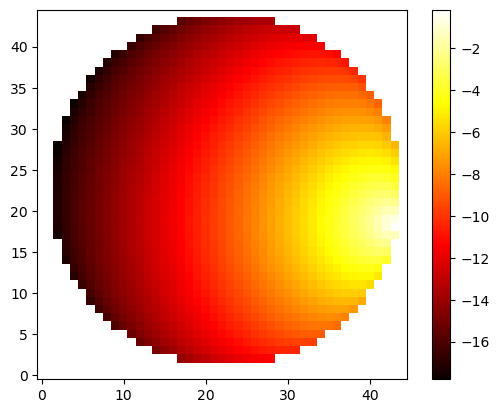

In [6]:
# We can plot the same data again, but in grid space
plt.imshow(np.log(np.abs(data.phi[:,:,0])), origin='lower')
plt.set_cmap('hot')
plt.colorbar()

Note that the field "phi" is already, very conveniently, reshaped according to the grid size. If you are unhappy with the current grid, you can also redo the whole process using a new grid, in which case the package will give you a warning before proceeding. For example,

/tmp/ipykernel_5619/1847420843.py:7: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(data.phi[:,:,0]), aspect=1.5, origin='lower') # use 1.5 because the stepsize of x and y axes are different


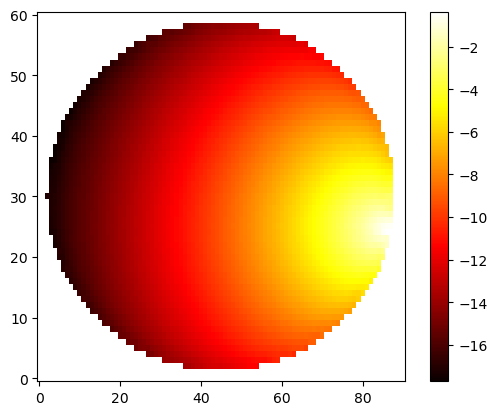

In [7]:
xgrid = np.arange(-45, 45.5, 1)
ygrid = np.arange(-45, 45.5, 1.5)
mesh.gen_intmat(xgrid, ygrid)
# Now convert the data
data.togrid(mesh)
# Plot, the same information again
plt.imshow(np.log(data.phi[:,:,0]), aspect=1.5, origin='lower') # use 1.5 because the stepsize of x and y axes are different
plt.set_cmap('hot')
plt.colorbar()

Now that we have already got the grid information in the mesh (in field "mesh.vol". The curious reader can print it and consult the API documentation), whenver we generate a new set of forward data, it will be automatically represented in grid/volumetric space.

For example, if we do generate some FD data, using the same mesh

/tmp/ipykernel_5619/3139363022.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(data.phi[:,:,0])), aspect=1.5, origin='lower') # use 1.5 because the stepsize of x and y axes are different


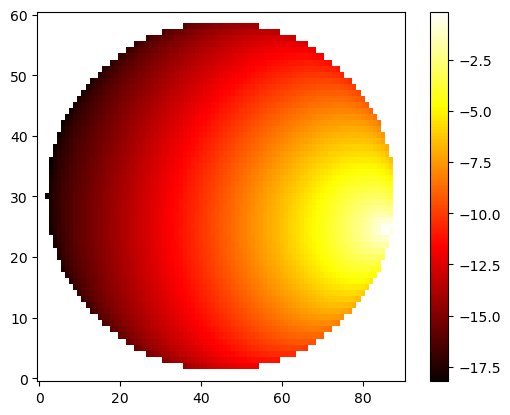

In [8]:
data = mesh.femdata(1e8)[0] # Not saving the convergence info; assuming 100Mhz modulation
# And plot the absolute amplitude of source 0
plt.imshow(np.log(np.abs(data.phi[:,:,0])), aspect=1.5, origin='lower') # use 1.5 because the stepsize of x and y axes are different
plt.set_cmap('hot')
plt.colorbar()

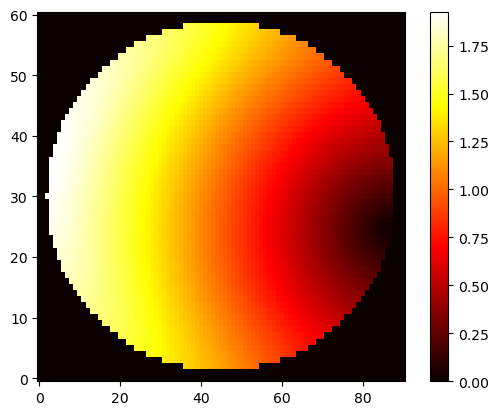

In [9]:
# Since it's frequency domain, we can of cource also plot the phase
plt.imshow(np.angle(data.phi[:,:,0]), aspect=1.5, origin='lower') # use 1.5 because the stepsize of x and y axes are different
plt.set_cmap('hot')
plt.colorbar()

Note how we calculate the phase: fluences in FD are now represented as complex numbers, and the phase is nothing but the angle defined by these complex numbers. Conveniently, NumPy provides us with the function ```np.angle()``` for exactly that purpose.

## TPSF and TR moments
Now let's move on to a different type of data: the temporal point spread function, or TPSF in short. Essentially, it indicates how the light propagates in a medium spatially *and* temporally, in response to a spatio-temporal impulse.

The $n$-th ($n=0,1,2,\ldots$) moment is defined as, for a function $f(t)$, $\int_{-\infty}^\infty t^nf(t)\,dt$. When we discuss time-resolved (hence the abbreviation TR) tissue optics, we are typically more interested in the following variant,
$$
\langle t^0\rangle = \int_0^\infty f(t)\,dt \\
$$
$$
\langle t^n\rangle = \frac{\int_0^\infty t^nf(t)\,dt}{\langle t^0\rangle}\quad n=1,2,\ldots \\
$$
Note that the lower limit of the integral has become 0, because TPSF is strictly zero before time zero. We can thus see that the zeroth moment coincides with the CW intensity of light, the first moment is the mean time of flight, the second moment can be translated into the variance, and so forth.

Let's actually restart the pipeline, for better clarity.

In [10]:
# load mesh
mesh = ff.base.stndmesh()
mesh.from_file('../meshes/standard/circle2000_86_stnd')
# define the grid
xgrid = np.arange(-45., 45, 2)
ygrid = np.arange(-45., 45, 2)
mesh.gen_intmat(xgrid, ygrid)
# generate the tpsf
data = mesh.femdata_tpsf(10e-9, 1e-11, savefield=1)[0] # The first two arguments are total time and time resolution, in seconds

Fixed sources
Sources integration functions loaded
Fixed detectors
Detectors integration functions loaded


Note that usually we can ignore the "savefield" argument and let it automatically be False, as we, most of the time, care only about the *measured* TPSF at the detectors. For demonstration purposes of the tutorial, let's set it to True for now. 

Also note that the first argument (total time) should be sufficiently large so that the full responses are captured, and the second argument (time resolution) to be sufficiently small, so that the solver is numerically stable. 

If we plot all the measured TPSFs in one plot, we have something like this

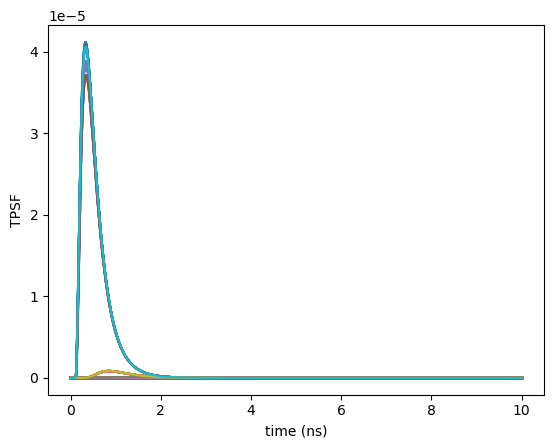

In [11]:
plt.figure()
plt.plot(data.time*1e9, data.tpsf.T) # x axis in ns
plt.xlabel('time (ns)')
plt.ylabel('TPSF')
plt.show()

<IPython.core.display.Javascript object>


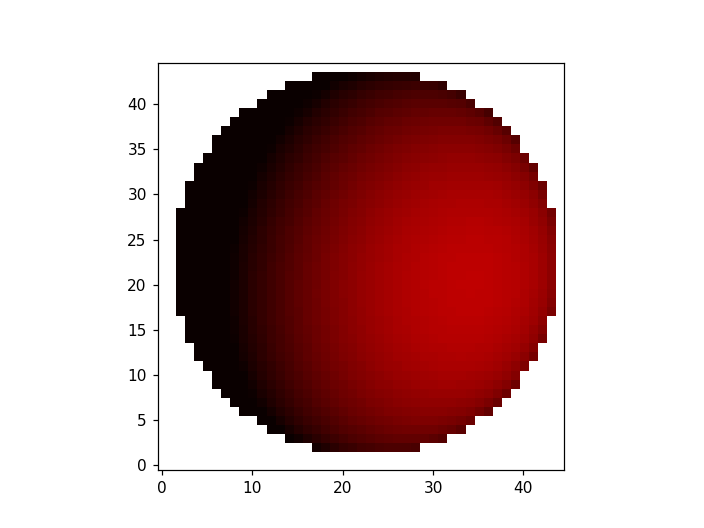

/tmp/ipykernel_5619/2326737662.py:8: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(np.abs(data.phi[:,:,0,i].squeeze())), vmin=-20, vmax=-1, animated=True, origin='lower')


In [12]:
%matplotlib notebook
fig, ax = plt.subplots()
plt.set_cmap('hot')
ims = []
for i in range(np.size(data.time)):
    if i%10:
        continue
    im = ax.imshow(np.log(np.abs(data.phi[:,:,0,i].squeeze())), vmin=-20, vmax=-1, animated=True, origin='lower')
    #if i == 0:
    #    ax.imshow(np.log(np.abs(data.phi[:,:,0,i].squeeze())), vmin=-20, vmax=-1)  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
plt.show()
#from IPython.display import HTML
#HTML(ani.to_html5_video())

You may have noticed that it took a while to generate the data, especially if you are using a non-GPU computer. This is because the FEM solver must be called at each time step, meaning that if you wish to simulate for longer, or use finer time resolution, the running time can be even longer.

This really motivates what we are going to learn next: if we are not concerned about the time traces, we can directly calculate the moments (normalized to the zeroth) and that's much more efficient. The theories can be found [here](https://doi.org/10.1364/AO.34.002683)

In [13]:
mdata = mesh.femdata_moments(2)[0] # 2 means calculating up to the 2nd moment

That was fast. We can of course compare the results and see if they agree with each other. Let's start with the zeroth moment

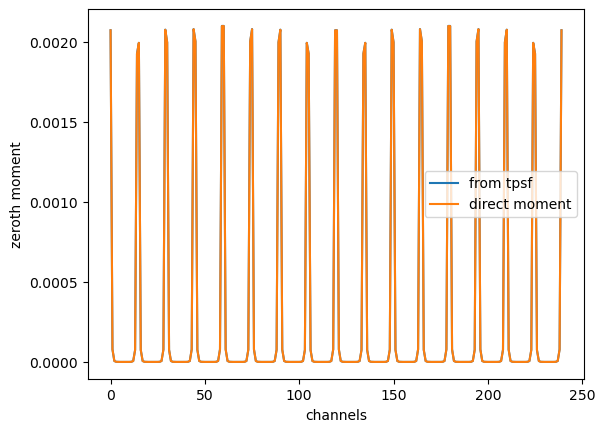

In [14]:
%matplotlib inline 
# let's switch back to the inline backend for regular figures
m0 = np.sum(data.tpsf, axis=1)
plt.figure()
plt.plot(m0)
plt.plot(mdata.moments[:,0])
plt.legend(['from tpsf', 'direct moment'])
plt.xlabel('channels')
plt.ylabel('zeroth moment')
plt.show()

Now let's do the same thing with first and second moments as well.

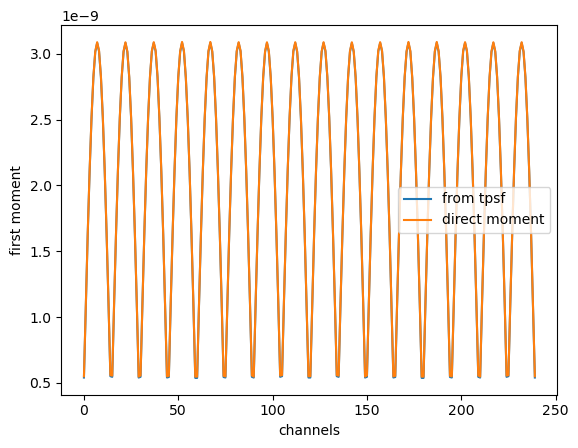

In [15]:
m1 = np.sum(data.tpsf*data.time, axis=1) / m0
plt.figure()
plt.plot(m1)
plt.plot(mdata.moments[:,1])
plt.legend(['from tpsf', 'direct moment'])
plt.xlabel('channels')
plt.ylabel('first moment')
plt.show()

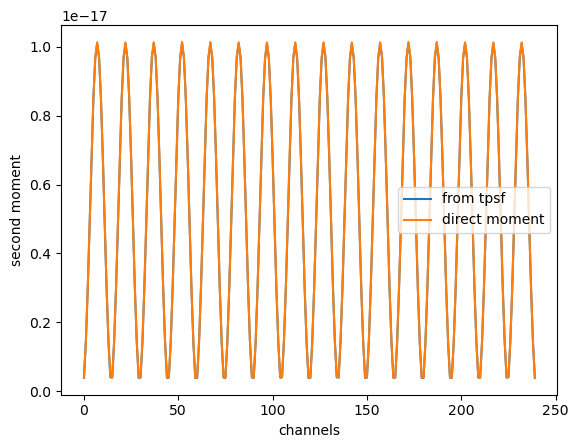

In [16]:
m2 = np.sum(data.tpsf*data.time**2, axis=1) / m0
plt.figure()
plt.plot(m2)
plt.plot(mdata.moments[:,2])
plt.legend(['from tpsf', 'direct moment'])
plt.xlabel('channels')
plt.ylabel('second moment')
plt.show()

As you can see, they all agree with each other very well. This should conclude our discussion on generating data using a standard mesh.

## Fluorescence
Now let's move on to our second mesh type: the fluorescence mesh. In physics terms, it is quite similar to a standard mesh, except that we now have to solve the diffusion equation twice, first for the excitation field, and subsequently for the fluorescence re-emission, where the source terms is simply the fluences of the excitation field scaled by the, in brief, fluorophore properties. A good introduction can be found [here](https://doi.org/10.1364/OE.15.004066)

And the data types we can simulate using this package are exactly the same as the standard mesh counterpart, consequently. Let's quickly go through them, and have a look at the data.

In [17]:
# load mesh
mesh = ff.base.fluormesh()
mesh.from_file('../meshes/fl/circle2000_86_fl')
# define the grid
xgrid = np.arange(-45., 45, 2)
ygrid = np.arange(-45., 45, 2)
mesh.gen_intmat(xgrid, ygrid)
# generate the CW data
data = mesh.femdata(0)[0]

Sources integration functions loaded
Detectors integration functions loaded


/tmp/ipykernel_5619/2819721112.py:4: RuntimeWarning: divide by zero encountered in log
  h1 = ax1.imshow(np.log(np.abs(data.phix[:,:,0])), origin='lower')
/tmp/ipykernel_5619/2819721112.py:7: RuntimeWarning: divide by zero encountered in log
  h2 = ax2.imshow(np.log(np.abs(data.phifl[:,:,0])), origin='lower')


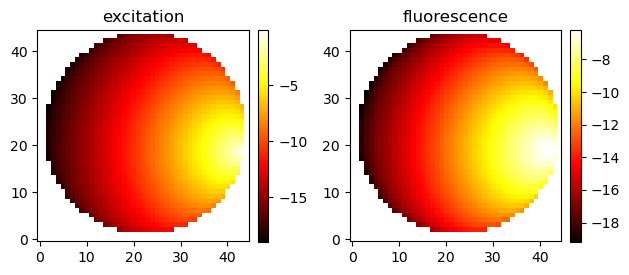

In [18]:
# and plot the excitation and re-emission at the first source
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.set_cmap('hot')
h1 = ax1.imshow(np.log(np.abs(data.phix[:,:,0])), origin='lower')
fig.colorbar(h1, fraction=0.046, pad=0.04)
ax1.set_title('excitation')
h2 = ax2.imshow(np.log(np.abs(data.phifl[:,:,0])), origin='lower')
fig.colorbar(h2, fraction=0.046, pad=0.04)
ax2.set_title('fluorescence')

plt.tight_layout()
plt.show()

And if the modulation frequency is non-zero, we can, analogous to the standard mesh, examine both the amplitude and the phase

/tmp/ipykernel_5619/2327971723.py:6: RuntimeWarning: divide by zero encountered in log
  h1 = axs[0,0].imshow(np.log(np.abs(data.phix[:,:,0])), origin='lower')
/tmp/ipykernel_5619/2327971723.py:9: RuntimeWarning: divide by zero encountered in log
  h2 = axs[0,1].imshow(np.log(np.abs(data.phifl[:,:,0])), origin='lower')


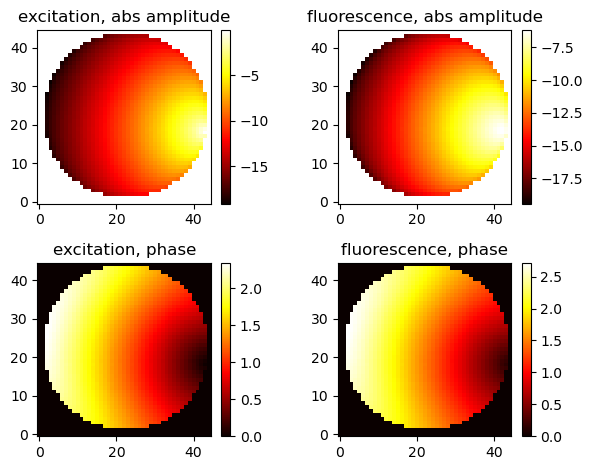

In [19]:
# generate the FD data
data = mesh.femdata(1e8)[0]
# plot
fig, axs = plt.subplots(2, 2)
plt.set_cmap('hot')
h1 = axs[0,0].imshow(np.log(np.abs(data.phix[:,:,0])), origin='lower')
axs[0,0].set_title('excitation, abs amplitude')
fig.colorbar(h1, fraction=0.046, pad=0.04)
h2 = axs[0,1].imshow(np.log(np.abs(data.phifl[:,:,0])), origin='lower')
axs[0,1].set_title('fluorescence, abs amplitude')
fig.colorbar(h2, fraction=0.046, pad=0.04)
h3 = axs[1,0].imshow(np.angle(data.phix[:,:,0]), origin='lower')
axs[1,0].set_title('excitation, phase')
fig.colorbar(h3, fraction=0.046, pad=0.04)
h4 = axs[1,1].imshow(np.angle(data.phifl[:,:,0]), origin='lower')
axs[1,1].set_title('fluorescence, phase')
fig.colorbar(h4, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

Let's now have a look at the time-resolved data, first the TPSF. Under the hood, the algorithm first calculates the TPSF of the excitation field, and subsequently utilizes the result to calculate the TPSF of the fluorescence re-emission. The two steps are also indicated in the printout.

In [20]:
data = mesh.femdata_tpsf(10e-9, 1e-11, savefield=True)[0] # again, set "savefield" to True. default is False

Excitation...
Emission...


<IPython.core.display.Javascript object>


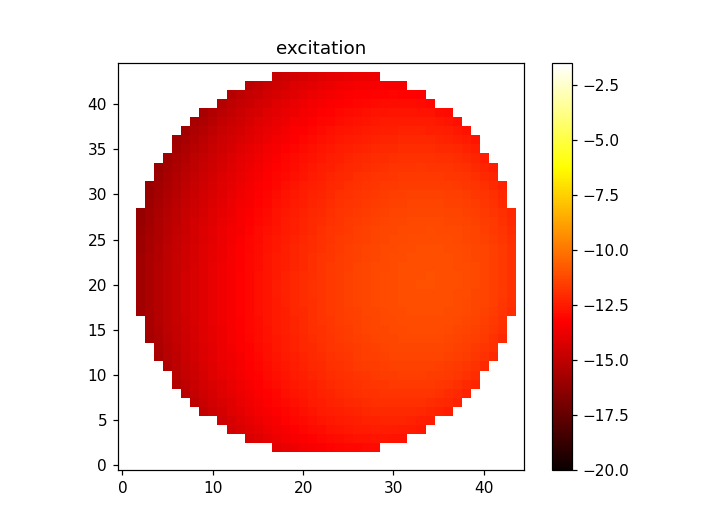

/tmp/ipykernel_5619/4161823265.py:8: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(np.abs(data.phix[:,:,0,i].squeeze())), vmin=-20, vmax=-1.5, animated=True, origin='lower')


In [21]:
%matplotlib notebook
fig, ax = plt.subplots()
plt.set_cmap('hot')
ims = []
for i in range(np.size(data.time)):
    if i%10:
        continue
    im = ax.imshow(np.log(np.abs(data.phix[:,:,0,i].squeeze())), vmin=-20, vmax=-1.5, animated=True, origin='lower')
    ax.set_title('excitation')
    ims.append([im])
fig.colorbar(im)
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
#from IPython.display import HTML
#HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>


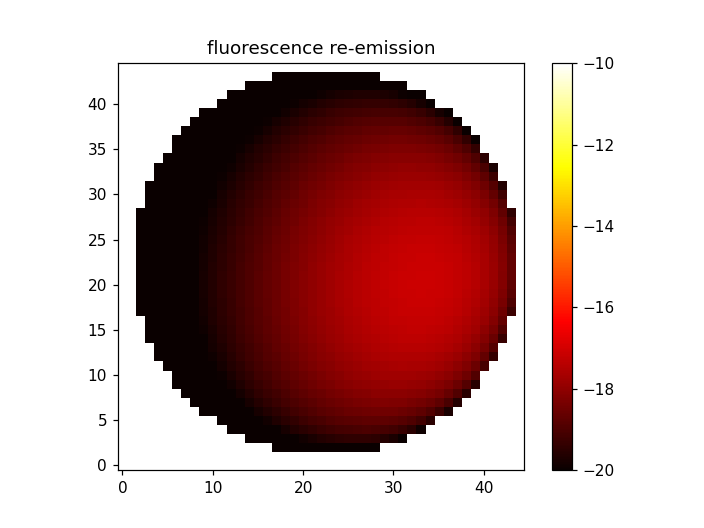

/tmp/ipykernel_5619/573581464.py:8: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(np.abs(data.phifl[:,:,0,i].squeeze())), vmin=-20, vmax=-10, animated=True, origin='lower')


In [22]:
%matplotlib notebook
fig, ax = plt.subplots()
plt.set_cmap('hot')
ims = []
for i in range(np.size(data.time)):
    if i%10:
        continue
    im = ax.imshow(np.log(np.abs(data.phifl[:,:,0,i].squeeze())), vmin=-20, vmax=-10, animated=True, origin='lower')
    ax.set_title('fluorescence re-emission')
    ims.append([im])
fig.colorbar(im)
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)
#from IPython.display import HTML
#HTML(ani.to_html5_video())

We can also directly calculate the moments, and do the similar comparison between moments calculated from TPSF and the ones that are directly calculated. The excitation part is exactly the same as the standard mesh, so let's only do so for the fluorescence re-emission.

In [23]:
mdata = mesh.femdata_moments()[0] # if no arguments are given, it calculates up to the third order

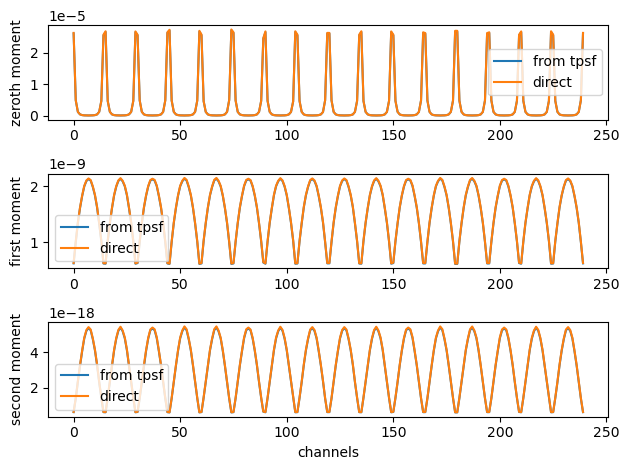

In [24]:
%matplotlib inline
m0 = np.sum(data.tpsffl, axis=1)
m1 = np.sum(data.tpsffl*data.time, axis=1)/m0
m2 = np.sum(data.tpsffl*data.time**2, axis=1)/m0

fig, (ax1,ax2,ax3) = plt.subplots(3)
ax1.plot(m0)
ax1.plot(mdata.momentsfl[:,0])
ax1.set_ylabel('zeroth moment')
ax1.legend(['from tpsf', 'direct'])

ax2.plot(m1)
ax2.plot(mdata.momentsfl[:,1])
ax2.set_ylabel('first moment')
ax2.legend(['from tpsf', 'direct'])

ax3.plot(m2)
ax3.plot(mdata.momentsfl[:,2])
ax3.set_ylabel('second moment')
ax3.set_xlabel('channels')
ax3.legend(['from tpsf', 'direct'])

plt.tight_layout()
plt.show()

## DCS
Now let's take a look at the final mesh type, the DCS mesh. The package generates DCS forward data by solving the "correlation diffusion equation", which takes the exact same form as the regular diffusion equation, with two exceptions: fluence now becomes the autocorrelation (G1 curve, as we usually call it), and the absorption coeffient becomes the inherent absorption coefficient plus a flow-related term. This allows us to, conveniently, use exactly the same solvers as the standard mesh. 

If you are not familiar with DCS theory, Section 2.9 of [this paper](https://doi.org/10.1088/0034-4885/73/7/076701) together with the papers cited can be an excellent introduction. Briefly, instead of inferring absorption from fluence as we typically do, we aim to infer flow from the autocorrelation curves in DCS. 

**Be noted**, that in NIRFASTer, we always assume the flow to be Brownian, or more precisely, $\langle\Delta r^2\rangle=6*\alpha Db*\tau$ (meaning of the equation is detailed in the paper linked above). If you examine the mesh carefully, you will three related fields: a, Db, and aDb. In the current version of the package, we only use the aDb term for calculating the forward data, and you will see in the next tutorial that it is also quantity we reconstruct. It is very rare to actually separate $\alpha$ and $Db$ in real-life applications, but we do keep the flexibility and possibility in our package.

Let's now load a slab mesh and have a look at the data.

In [25]:
mesh = ff.base.dcsmesh()
mesh.from_file('../meshes/dcs/slab_dcs')
# define the time vector. It is usually a good idea to use log scale
tau = np.logspace(-7,-3,128)
data = mesh.femdata(tau)[0]

Sources integration functions loaded
Detectors integration functions loaded


Now let's have a look at the G1 curves

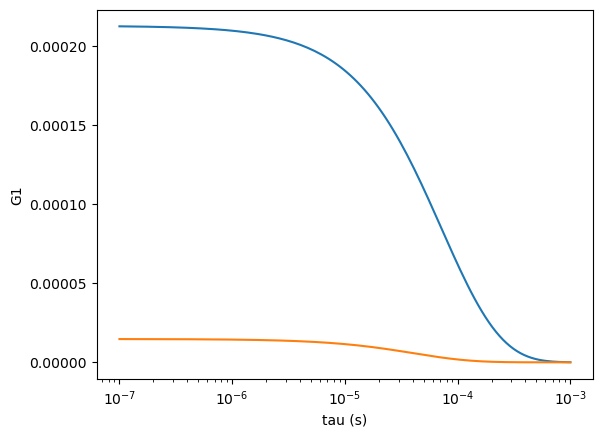

In [26]:
plt.figure()
plt.semilogx(tau, data.G1_DCS.T)
plt.xlabel('tau (s)')
plt.ylabel('G1')
plt.show()

First note that when calculating the forward data, we did not convert the data to volumetric space this time. We can of course still do that, but since we are only concerned about the boundary measurements for now, it is ok to skip this step.

We can see that the two curves are at very different amplitudes. This is simply because the source-detector distances are different, and if the photons have to travel for longer distances, the autocorrelation would, of course, be lower. If we are only concerned about the shapes of the curves, we can instead look at the normalized autocorrelation curves, or the $g_1$ (lowercase) curves, which strictly start from 1 when $\tau=0$

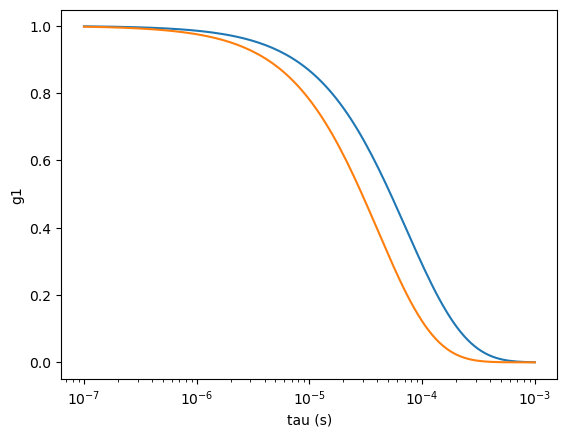

In [27]:
plt.figure()
plt.semilogx(tau, data.g1_DCS.T)
plt.xlabel('tau (s)')
plt.ylabel('g1')
plt.show()

Now, we have concluded the forward data generation. In the next tutorial, we will have a look at the Jacobians.